In [1]:
%load_ext autoreload
%autoreload 2

# Training

In this notebook we show the overall workflow to train a superresolution model. A standalone training script is provided in `train.py`.

## Data

Our dataset is formed of pairs of High-Resolution and Low-Resolution images. In this case, we have 384x384 Satellogic images and 384x384 matching Sentinel 2. Since the resolution of the Sentinel 2 is 10m and Satellogic is 1m, we center crop the HR images to 380x380 and the LR images to 38x38 so they match.

In [25]:
from eotdl.pytorch.superresolution import ESRTDatamodule
from glob import glob
import os

# load paths of HR imagery
hr_paths = glob("data/tifs/satellogic/*.tif")
# remove images without matching LR imagery
remove = []
for path in hr_paths:
    lr_path = path.replace("satellogic", "sentinel2").replace("_TOA.tif", "_S2L2A.tiff")
    if not os.path.exists(lr_path):
        remove.append(path)
hr_paths = [p for p in hr_paths if p not in remove]
lr_paths = [p.replace("satellogic", "sentinel2").replace("_TOA.tif", "_S2L2A.tiff") for p in hr_paths]

# create datamodule
dm = ESRTDatamodule(
    hr_paths,
    lr_paths,
    upscale = 2,
    batch_size = 5,
    val_size = 0.2,
    resize = False # only to see original hr images, for training always set to True
)

dm.setup()


Using 291 training images and 72 validation images


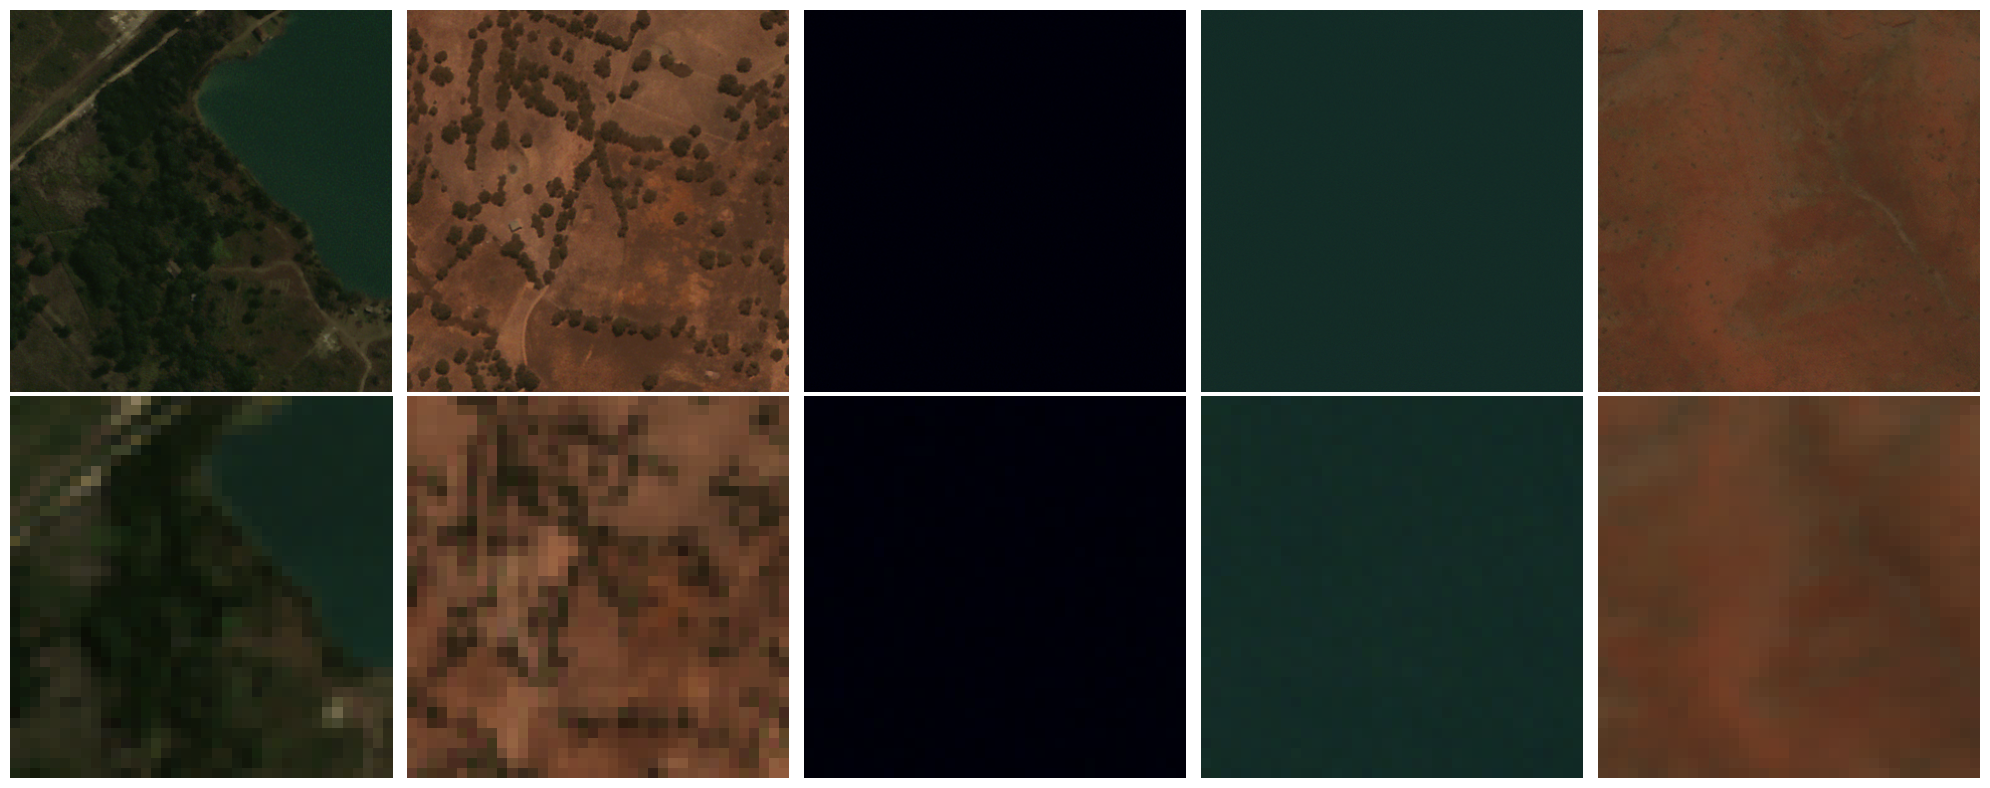

In [27]:
import matplotlib.pyplot as plt

batch = next(iter(dm.train_dataloader(shuffle=False)))
lr_images, hr_images = batch

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    hr_img = hr_images[i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(hr_img[..., :3])
    axes[0, i].axis('off')
for i in range(5):
    lr_img = lr_images[i].permute(1, 2, 0).numpy()
    axes[1, i].imshow(lr_img[..., :3])
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [28]:
lr_images.shape, hr_images.shape

(torch.Size([5, 4, 38, 38]), torch.Size([5, 4, 380, 380]))

During training, we resize HR image to match the target upsacling factor.

In [31]:
dm = ESRTDatamodule(
    hr_paths,
    lr_paths,
    upscale = 2,
    batch_size = 5,
    val_size = 0.2,
    resize = True # only to see original hr images, for training always set to True
)

dm.setup()

Using 291 training images and 72 validation images


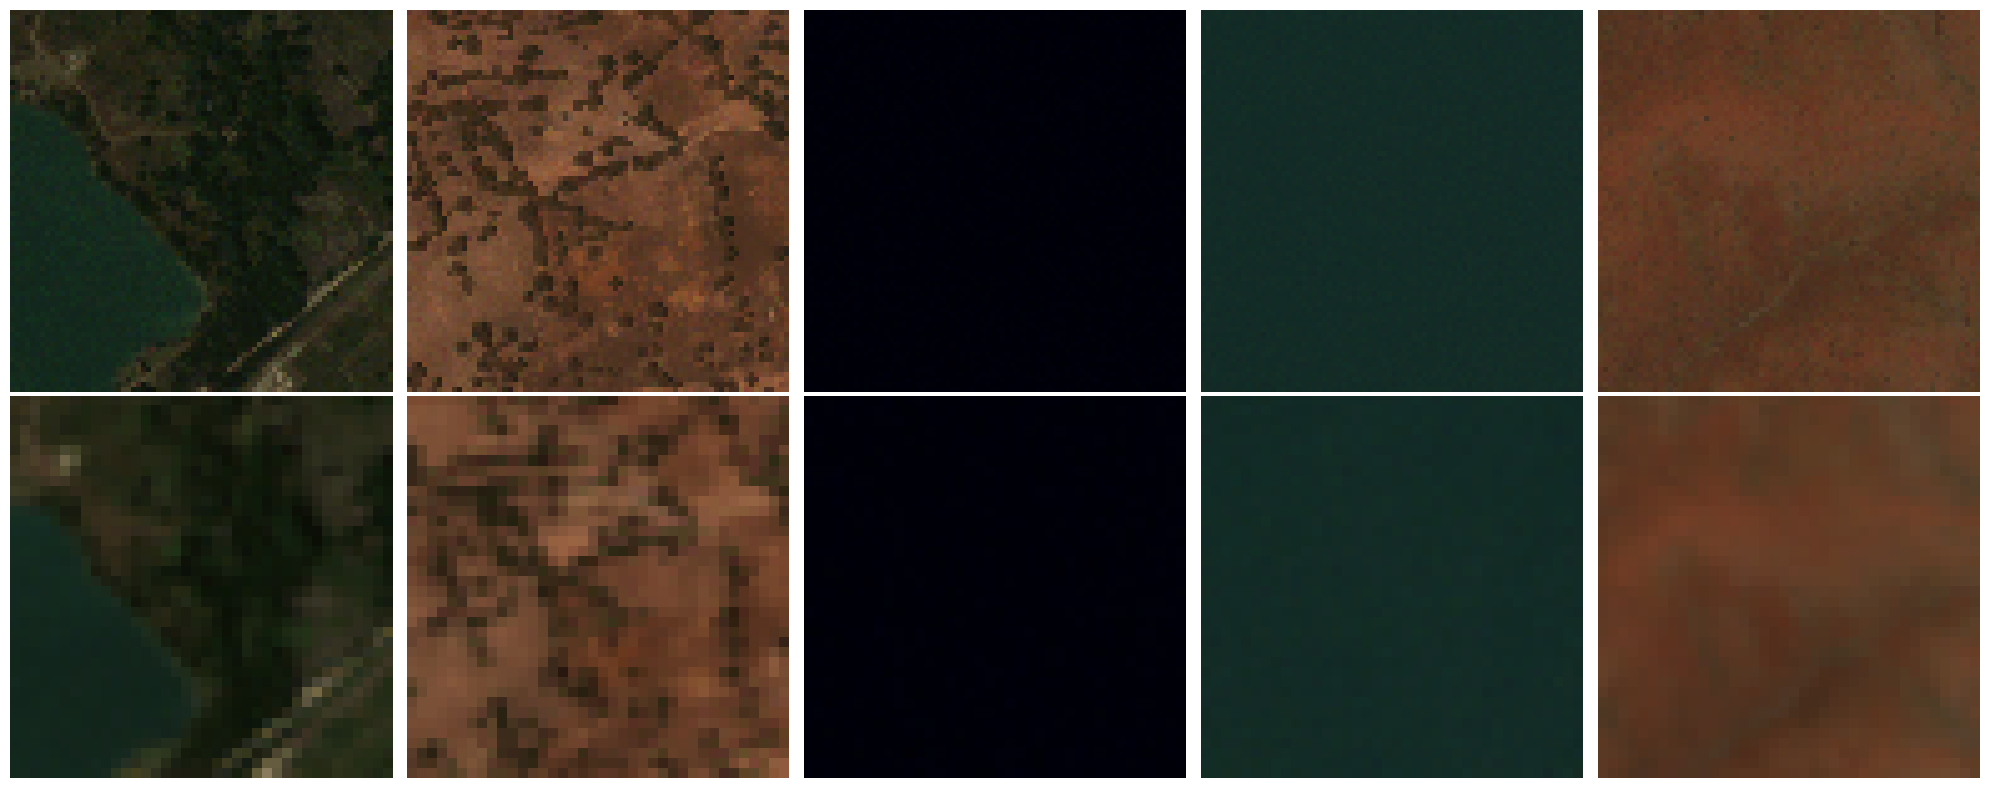

In [34]:
import matplotlib.pyplot as plt

batch = next(iter(dm.train_dataloader(shuffle=False)))
lr_images, hr_images = batch

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    hr_img = hr_images[i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(hr_img[..., :3])
    axes[0, i].axis('off')
for i in range(5):
    lr_img = lr_images[i].permute(1, 2, 0).numpy()
    axes[1, i].imshow(lr_img[..., :3])
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Model

In [36]:
from eotdl.pytorch.superresolution import ESRTModule

module = ESRTModule(
    upscale=2,
)

output = module(lr_images)

output.shape, hr_images.shape

(torch.Size([5, 4, 76, 76]), torch.Size([5, 4, 76, 76]))

## Training

For training, please use the `train.py` script.

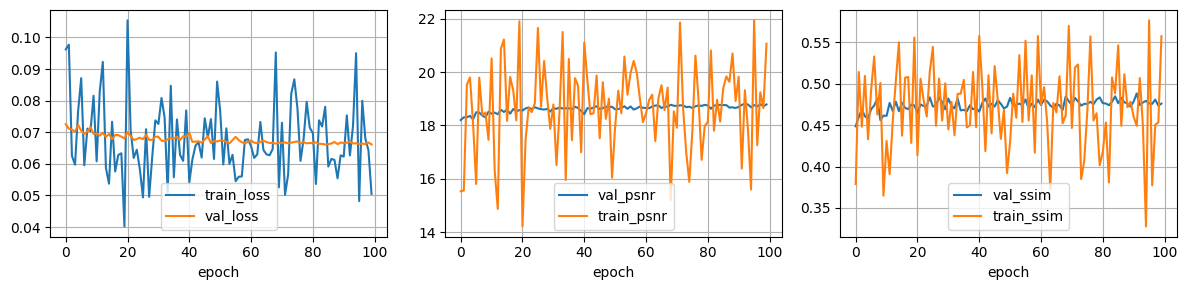

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/esrt_2x'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/esrt_2x/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_psnr', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_psnr', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='val_ssim', kind='line', ax=axs[2], grid=True)
metrics.plot(x='epoch', y='train_ssim', kind='line', ax=axs[2], grid=True)
plt.tight_layout()
plt.show()

## Export

In [20]:
from src.module import ESRTModule

checkpoint = 'checkpoints/esrt_ws_epoch=092_val_psnr=18.81008.ckpt'

module = ESRTModule.load_from_checkpoint(checkpoint)

module.eval();

In [21]:
from src.dm import ESRTDatamodule

dm = ESRTDatamodule(
    path = "/fastdata/superres",
    upscale = 2,
    batch_size = 5,
)

dm.setup()

Found 10761 images (removed 0 images)
Using 8609 training images and 2152 validation images


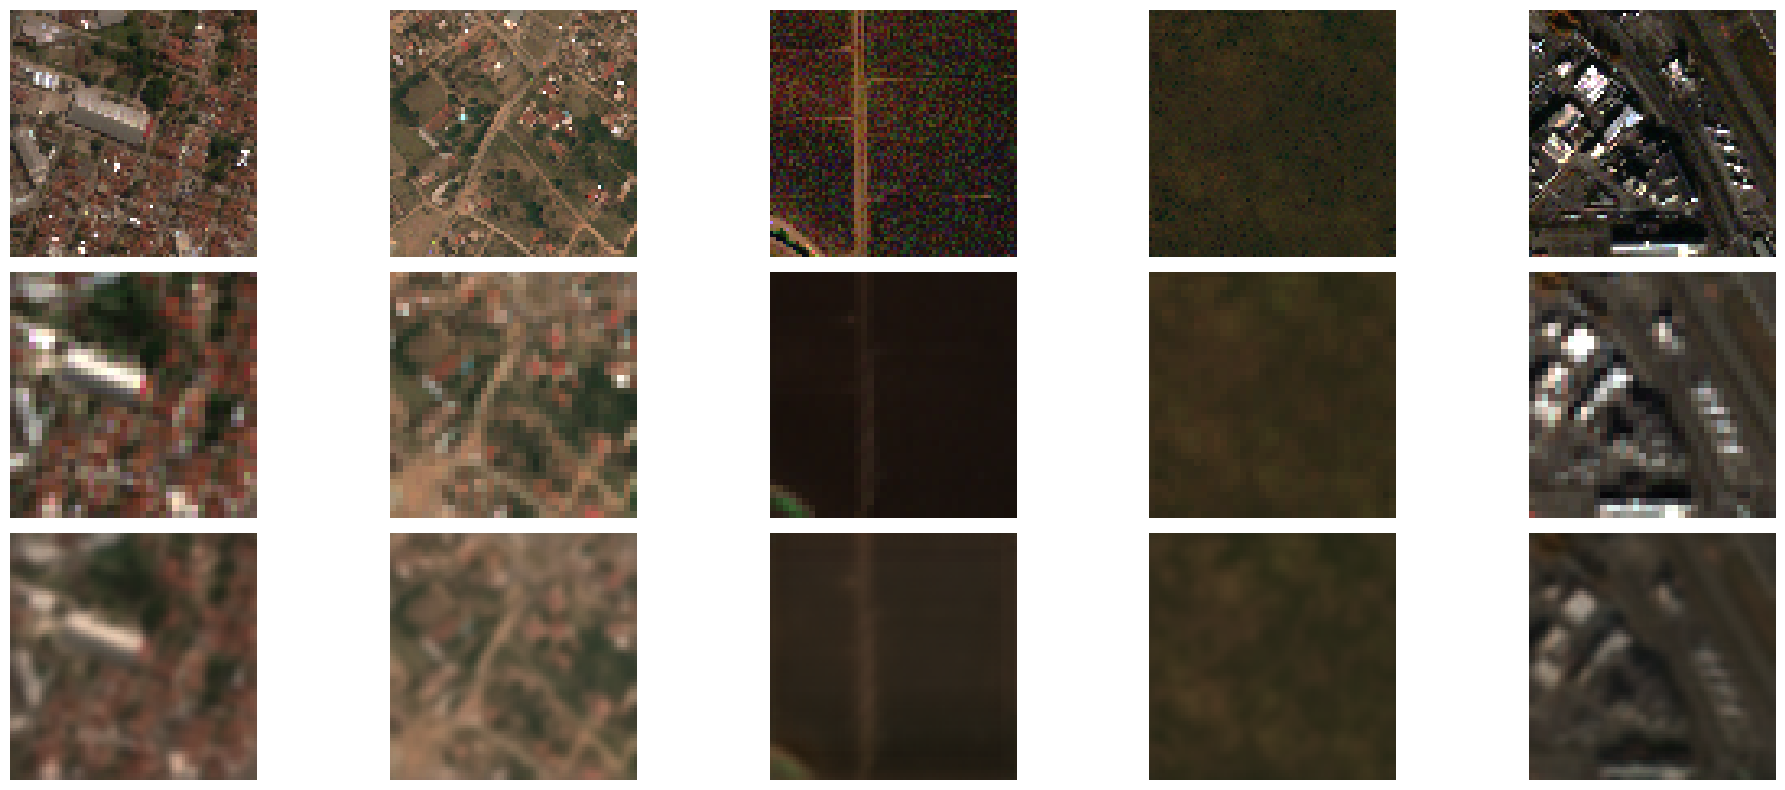

In [26]:
import matplotlib.pyplot as plt
import torch

batch = next(iter(dm.val_dataloader(shuffle=True)))
lr_images, hr_images = batch

with torch.no_grad():   
    preds = module(lr_images.to(module.device)).cpu()

fig, axes = plt.subplots(3, 5, figsize=(20, 8))
for i in range(5):
    hr_img = hr_images[i].permute(1, 2, 0)
    axes[0, i].imshow(hr_img[..., :3])
    axes[0, i].axis('off')
for i in range(5):
    lr_img = lr_images[i].permute(1, 2, 0)
    axes[1, i].imshow(lr_img[..., :3])
    axes[1, i].axis('off')
for i in range(5):
    pred_img = preds[i].permute(1, 2, 0)
    axes[2, i].imshow(pred_img[..., :3])
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [23]:
import torch 

#  this model cannot be exported to onnx 

# torch.onnx.export(
# 	module.eval().cpu(),
# 	lr_images,
# 	'outputs/model.onnx',
# 	export_params=True,
# 	input_names=['input'],
# 	output_names=['output'],
# 	dynamic_axes={
# 		'input': {
# 			0: 'batch_size',
# 			2: 'height',
# 			3: 'width'
# 		}, 
# 		'output': {
# 			0: 'batch_size'
# 		}
# 	}
# )

# this model cannote be scripted

# scripted = torch.jit.script(module.model.eval().cpu())

# scripted.save('outputs/model.pt')

## Ingest

Finally, we ingest the model into the EOTDL

In [28]:
import os

# create README.md

text = """---
name: SuperResolutionUseCase
authors: 
  - Juan B. Pedro
license: free
source: https://github.com/earthpulse/eotdl/blob/main/tutorials/usecases/useCaseB/training.ipynb
---

# SuperResolutionUseCase

This model was trained to perform super resolution of Sentinel-2 imagery as part of the EOTDL [use case B](https://github.com/earthpulse/eotdl/blob/main/tutorials/usecases/useCaseB).

Learn more at https://github.com/earthpulse/eotdl/blob/main/tutorials/usecases/useCaseB/training.ipynb
"""

os.makedirs('outputs', exist_ok=True)

with open(f"outputs/README.md", "w") as outfile:
    outfile.write(text)

In [30]:
import shutil

shutil.copy2(checkpoint, 'outputs/checkpoint.ckpt')
shutil.copy2('inference.ipynb', 'outputs/inference.ipynb')
shutil.copytree('src', 'outputs/src', dirs_exist_ok=True)


'outputs/src'

In [31]:
!eotdl version

EOTDL Version: 2025.05.26-4


In [32]:
!eotdl models ingest -p outputs

Ingesting directory: outputs
Ingesting files: 100%|██████████████████████████| 11/11 [00:06<00:00,  1.61it/s]
